Some detailed steps that are not important like combining files into one file etc. are documented in "data_preparation_new.ipynb"

# To Do: 


In [1]:
# imports
import xarray as xr
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt 
import geopandas as gpd # this is used in the hydromt version of aggregation
import glob # to create a dictionary for combininc the NC files
import math
import os
from datetime import datetime as dt

%matplotlib inline

/var/folders/4b/zw1v3tjx7tz9ffly5_lhgxc80000gp/T/ipykernel_22019/3130474409.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd # this is used in the hydromt version of aggregation


In [2]:
### new, somehow necessary to import xagg
os.environ["ESMFMKFILE"] = "/Users/jonathanschieren/opt/anaconda3/envs/hydromt/lib/esmf.mk"

In [3]:
import xagg as xa

Ensemble mean, 0.1 degree regular grid
version 26.0e October 2022, period: 1950-01-01 - 2022-06-30
Link: https://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php#datafiles

TG = daily mean temperature [°C] \
TN = daily minimum temperature [°C] \
TX = daily maximum temperature [°C] \
RR = sum of daily precipitation [mm] \
PP = daily averaged sea level pressure [hPa] \
HU = daily averaged relative humidity [%] \
FG = daily mean wind speed at 10 m height [m/s]\
QQ = surface shortwave downwelling radiation [W/m2] \
ELEV = land surface elevation above sea level [m]

# 1. Load Data & Clip [run only once!]

## 1.1 Load EOBS data

In [ ]:
# load the full files (they are already pre-clipped from the "data_preparation_new.ipynb" notebook)
RR = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/rr_ens_mean_0.1deg_reg_v26.0e_cl_old.nc', mask_and_scale=False)
TN = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tn_ens_mean_0.1deg_reg_v26.0e_cl_old.nc', mask_and_scale=False)
TX = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tx_ens_mean_0.1deg_reg_v26.0e_cl_old.nc', mask_and_scale=False)
TG = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tg_ens_mean_0.1deg_reg_v26.0e_cl_old.nc', mask_and_scale=False)
PP = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/pp_ens_mean_0.1deg_reg_v26.0e_cl_old.nc', mask_and_scale=False)
HU = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/hu_ens_mean_0.1deg_reg_v26.0e_cl_old.nc', mask_and_scale=False)
FG = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/fg_ens_mean_0.1deg_reg_v26.0e_cl_old.nc', mask_and_scale=False)
QQ = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/qq_ens_mean_0.1deg_reg_v26.0e_cl_old.nc', mask_and_scale=False)

In [ ]:
# load elevation file
ELEV = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/elev_ens_0.1deg_reg_v26.0e.nc', mask_and_scale=True)

## 1.2 Load ERA5Land data
Note: 
- Steps like aggregating the annual files are documented in "data_preparation_new.ipynb"

In [ ]:
# load albedo 
ALB = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/era5land/alb_combi/ERA5_f_alb_mean_total.nc', mask_and_scale=True)

In [ ]:
# sort the latitude values
ALB = ALB.sortby('latitude', ascending=True)

In [ ]:
# load the correct PET which is calculated based on the last hour of each day 
PET_last = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/era5land/pet_combi/ERA5_pet_total_daily_last.nc', mask_and_scale=True)

In [ ]:
# sort the latitude values
PET_last = PET_last.sortby('latitude', ascending=True)

## 1.1 Reduce spatial extent with rectangle

In [ ]:
# Clip raster data to approximate extent of LamaH dataset
# Corner points in epsg:4236 -> But we did not assign a CRS yet
xmin_C = 8
xmax_C = 18 # would have to be 19 to use basin delineations A and B but we don't need it 
ymin_C = 46
ymax_C = 50

# 
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [xmin_C, ymin_C],
            [xmin_C, ymax_C],
            [xmax_C, ymax_C],
            [xmax_C, ymin_C],
            [xmin_C, ymin_C]
        ]]
    }
]

# Reduce size
RR_r = RR.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))
TN_r = TN.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))
TX_r = TX.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))
TG_r = TG.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))
PP_r = PP.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))
HU_r = HU.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))
FG_r = FG.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))
QQ_r = QQ.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))

# albedo 
ALB_r = ALB.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))


# elevation
ELEV_r = ELEV.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))

In [ ]:
# PET last
PET_last_r = PET_last.sel(longitude=slice(xmin_C, xmax_C), latitude=slice(ymin_C, ymax_C))

## 1.2 Reduce temporal dimension 
- this is not needed for elevation as it has no temporal dimension

In [ ]:
# reduce temporal extent
RR_rr = RR_r.sel(time=slice('1981-01-01','2021-12-31'))
TN_rr = TN_r.sel(time=slice('1981-01-01','2021-12-31'))
TX_rr = TX_r.sel(time=slice('1981-01-01','2021-12-31'))
TG_rr = TG_r.sel(time=slice('1981-01-01','2021-12-31'))
PP_rr = PP_r.sel(time=slice('1981-01-01','2021-12-31'))
HU_rr = HU_r.sel(time=slice('1981-01-01','2021-12-31'))
FG_rr = FG_r.sel(time=slice('1981-01-01','2021-12-31'))
QQ_rr = QQ_r.sel(time=slice('1981-01-01','2021-12-31'))

# albedo 
ALB_rr = ALB_r.sel(time=slice('1981-01-01','2021-12-31'))

In [ ]:
# PET last 
PET_last_rr = PET_last_r.sel(time=slice('1981-01-01','2021-12-31'))

In [ ]:
PET_last_rr

## 1.3 Save to NetCDF 

In [ ]:
RR_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/rr_ens_mean_0.1deg_reg_v26.0e_cl.nc')
TN_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tn_ens_mean_0.1deg_reg_v26.0e_cl.nc')
TX_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tx_ens_mean_0.1deg_reg_v26.0e_cl.nc')
TG_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tg_ens_mean_0.1deg_reg_v26.0e_cl.nc')
PP_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/pp_ens_mean_0.1deg_reg_v26.0e_cl.nc')
HU_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/hu_ens_mean_0.1deg_reg_v26.0e_cl.nc')
FG_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/fg_ens_mean_0.1deg_reg_v26.0e_cl.nc')
QQ_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/qq_ens_mean_0.1deg_reg_v26.0e_cl.nc')

# albedo
ALB_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/ALB_ERA5Land_cl.nc')

# elevation 
ELEV_r.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/elev_ens_0.1deg_reg_v26.0e_cl.nc')

In [ ]:
# PET last 
PET_last_rr.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/PET_last_ERA5Land_cl.nc')

# 2 Load the clipped files & elevation & shapefile

In [4]:
# load clipped files
RR_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/rr_ens_mean_0.1deg_reg_v26.0e_cl.nc', mask_and_scale=True)
TN_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tn_ens_mean_0.1deg_reg_v26.0e_cl.nc', mask_and_scale=True)
TX_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tx_ens_mean_0.1deg_reg_v26.0e_cl.nc', mask_and_scale=True)
TG_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/tg_ens_mean_0.1deg_reg_v26.0e_cl.nc', mask_and_scale=True)
PP_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/pp_ens_mean_0.1deg_reg_v26.0e_cl.nc', mask_and_scale=True)
HU_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/hu_ens_mean_0.1deg_reg_v26.0e_cl.nc', mask_and_scale=True)
FG_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/fg_ens_mean_0.1deg_reg_v26.0e_cl.nc', mask_and_scale=True)
QQ_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/qq_ens_mean_0.1deg_reg_v26.0e_cl.nc', mask_and_scale=True)

# albedo 
ALB_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/ALB_ERA5Land_cl.nc', mask_and_scale=True)

# elevation
ELEV_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/elev_ens_0.1deg_reg_v26.0e_cl.nc')

/Users/jonathanschieren/opt/anaconda3/envs/hydromt/lib/python3.10/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'fg' has multiple fill values {-9999, '-9999s'}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [5]:
# PET last
PET_last_cl_xr = xr.open_dataarray('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/PET_last_ERA5Land_cl.nc', mask_and_scale=True)

## 2.1 Write CRS (is this correct?)

In [6]:
# Define CRS
RR_cl_xr.rio.write_crs("epsg:4326", inplace=True)
TN_cl_xr.rio.write_crs("epsg:4326", inplace=True)
TX_cl_xr.rio.write_crs("epsg:4326", inplace=True)
TG_cl_xr.rio.write_crs("epsg:4326", inplace=True)
PP_cl_xr.rio.write_crs("epsg:4326", inplace=True)
HU_cl_xr.rio.write_crs("epsg:4326", inplace=True)
FG_cl_xr.rio.write_crs("epsg:4326", inplace=True)
QQ_cl_xr.rio.write_crs("epsg:4326", inplace=True)

# albedo 
ALB_cl_xr.rio.write_crs("epsg:4326", inplace=True)

# elevaiton
ELEV_cl_xr.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'elevation' (latitude: 40, longitude: 100)>
[4000 values with dtype=float32]
Coordinates:
  * longitude    (longitude) float64 8.05 8.15 8.25 8.35 ... 17.75 17.85 17.95
  * latitude     (latitude) float64 46.05 46.15 46.25 ... 49.75 49.85 49.95
    spatial_ref  int64 0
Attributes:
    units:      metres
    long_name:  Elevation

In [7]:
# PET last
PET_last_cl_xr.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'pev' (time: 14975, latitude: 41, longitude: 101)>
[62011475 values with dtype=float32]
Coordinates:
  * longitude    (longitude) float32 8.0 8.1 8.2 8.3 8.4 ... 17.7 17.8 17.9 18.0
  * latitude     (latitude) float32 46.0 46.1 46.2 46.3 ... 49.7 49.8 49.9 50.0
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31
    spatial_ref  int64 0
Attributes:
    units:      m
    long_name:  Potential evaporation

## 2.2 Load and reproject the shapefile

In [8]:
# Shapefile 
shape_C = gpd.read_file('/Users/jonathanschieren/Desktop/msc_thesis/data/lamah/hourly/C_basins_intermediate_lowimp/3_shapefiles/Basins_C.shp')

# Reproject to epsg:4326
shape_C_4326 = shape_C.to_crs(epsg=4326)

In [9]:
print("Before", shape_C.crs)
print("After", shape_C_4326.crs)

Before EPSG:3035
After EPSG:4326


In [142]:
# create array of catchment ID's
IDs = np.zeros(shape_C_4326.shape[0])
for i in range(shape_C_4326.shape[0]):
    IDs[i] = shape_C_4326.ID[i]

## 2.3 Shift and clip the grid of the ERA5Land data (albedo, PET) and shift the grid of wind speed by a tiny bite from 8.05 to 8.0469..
- For some reason the grid of wind speed is 8.05 while all others from EOBS are 8.0469.. it does not really matter but we will fix it here 

In [11]:
# starting lat 
start_lat_alb = 46.0
start_lon_alb = 8.0

# starting lon 
start_lat_eobs = 46.04986
start_lon_eobs = 8.04986

# differences
lat_shift = start_lat_eobs - start_lat_alb
lon_shift = start_lon_eobs - start_lon_alb

In [12]:
# shift albedo 
ALB_cl_xr = ALB_cl_xr.assign_coords(latitude=ALB_cl_xr.latitude + lat_shift,
                                              longitude=ALB_cl_xr.longitude + lon_shift)

In [13]:
# Remove the last value along the latitude dimension
ALB_cl_xr = ALB_cl_xr.isel(latitude=slice(None, -1))

# Remove the last value along the longitude dimension
ALB_cl_xr = ALB_cl_xr.isel(longitude=slice(None, -1))

In [14]:
# minimally shift grid of wind speed (this is now only affecting the original 10m, as we have alread computed the 2m but does not really matter)
# starting lat 
start_lat_alb = 46.05
start_lon_alb = 8.05

# starting lon 
start_lat_eobs = 46.04986
start_lon_eobs = 8.04986

# differences
lat_shift = start_lat_eobs - start_lat_alb
lon_shift = start_lon_eobs - start_lon_alb


In [15]:
# shift wind
FG_cl_xr_shifted = FG_cl_xr.assign_coords(latitude=FG_cl_xr.latitude + lat_shift,
                                              longitude=FG_cl_xr.longitude + lon_shift)

In [16]:
# shift PET last 
PET_last_cl_xr = PET_last_cl_xr.assign_coords(latitude=PET_last_cl_xr.latitude + lat_shift,
                                              longitude=PET_last_cl_xr.longitude + lon_shift)

In [17]:
# Remove the last value along the latitude dimension
PET_last_cl_xr = PET_last_cl_xr.isel(latitude=slice(None, -1))

# Remove the last value along the longitude dimension
PET_last_cl_xr = PET_last_cl_xr.isel(longitude=slice(None, -1))

In [18]:
PET_last_cl_xr

<xarray.DataArray 'pev' (time: 14975, latitude: 40, longitude: 100)>
[59900000 values with dtype=float32]
Coordinates:
  * longitude    (longitude) float32 8.0 8.1 8.2 8.3 8.4 ... 17.6 17.7 17.8 17.9
  * latitude     (latitude) float32 46.0 46.1 46.2 46.3 ... 49.6 49.7 49.8 49.9
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31
    spatial_ref  int64 0
Attributes:
    units:      m
    long_name:  Potential evaporation

# 3. Analyse and fill missing data and scale

## 3.1 Find and interpolate missing values

In [19]:
# function for missing data 
def missing(dataarray):
    
    # missing values
    missing_values = dataarray.isnull()
    
    # missing values per time step 
    count_missing = missing_values.sum(dim='time')
    
    # total missing 
    total_missing = missing_values.sum()
    
    # percentage missing 
    percentage = total_missing / dataarray.size * 100

    
    return total_missing, percentage

In [20]:
# mean temperature 
total_missing_TG, percentage_TG = missing(TG_cl_xr)

In [21]:
# minimum temperature 
total_missing_TN, percentage_TN = missing(TN_cl_xr)

In [22]:
# maximum temperature
total_missing_TX, percentage_TX = missing(TX_cl_xr)

In [23]:
# precipitation 
total_missing_RR, percentage_RR = missing(RR_cl_xr)

In [24]:
# sea level pressure
total_missing_PP, percentage_PP = missing(PP_cl_xr)

In [25]:
# relative humidity
total_missing_HU, percentage_HU = missing(HU_cl_xr)

In [26]:
# wind speed 
total_missing_FG, percentage_FG = missing(FG_cl_xr)

/Users/jonathanschieren/opt/anaconda3/envs/hydromt/lib/python3.10/site-packages/xarray/coding/variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [27]:
# shortwave radiation 
total_missing_QQ, percentage_QQ = missing(QQ_cl_xr)

In [28]:
# albedo 
total_missing_ALB, percentage_ALB = missing(ALB_cl_xr)

In [29]:
# PET last 
total_missing_PET_last, percentage_PET_last = missing(PET_last_cl_xr)

In [30]:
# print missing values: 
print("Mean temp", total_missing_TG.values, percentage_TG.values)
print("Minimum temp", total_missing_TN.values, percentage_TN.values)
print("Maximum temp", total_missing_TX.values, percentage_TX.values)
print("Precipitation", total_missing_RR.values, percentage_RR.values)
print("Sea level pressure", total_missing_PP.values, percentage_PP.values)
print("Relative humidity", total_missing_HU.values, percentage_HU.values)
print("Wind speed", total_missing_FG.values, percentage_FG.values)
print("Shortwave radiation", total_missing_QQ.values, percentage_QQ.values)
print("Albedo", total_missing_ALB.values, percentage_ALB.values)



Mean temp 0 0.0
Minimum temp 0 0.0
Maximum temp 0 0.0
Precipitation 0 0.0
Sea level pressure 0 0.0
Relative humidity 556148 0.9284607679465775
Wind speed 14664 0.024480801335559268
Shortwave radiation 0 0.0
Albedo 0 0.0


In [31]:
# interpolation function 
def spatial_interpolate_missing(dataarray):
    # Iterate through each time step
    for t in dataarray.time:
        # Check if there are missing values at the current time step
        if dataarray.sel(time=t, method="nearest").isnull().any():
            # Interpolate spatially for the current time step
            dataarray.loc[{"time": t}] = dataarray.sel(time=t, method="nearest").rio.interpolate_na()

    return dataarray

In [32]:
FG_cl_xr = spatial_interpolate_missing(FG_cl_xr)

In [33]:
HU_cl_xr = spatial_interpolate_missing(HU_cl_xr)

## 3.2 Convert the PET from ERA5Land from m to mm 
Note: 
**PET in ERA5Land is computed as open water evaporation**

In [34]:
# convert PET last to mm 
PET_last_mm_cl_xr = PET_last_cl_xr * -1000

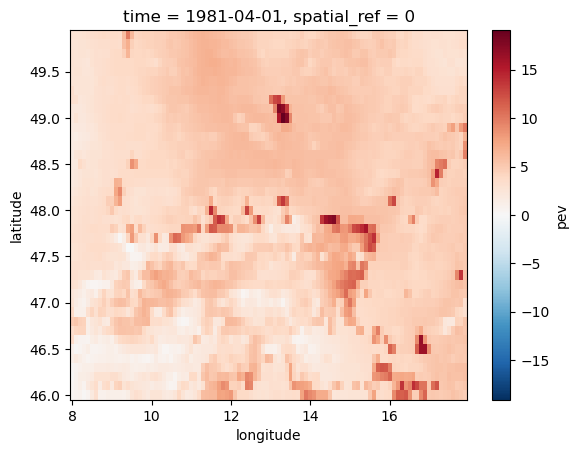

In [35]:
date_test = "1981-04-01"
plot = PET_last_mm_cl_xr.sel(time=date_test)
plot.plot()

# 4. Calculate PET based on Penman-Monteith (FAO) 
- use EOBS observation + albedo from ERA5Land

IMPORTANT: 
**Some functions are taken from pyeto package Github code**
https://github.com/woodcrafty/PyETo/blob/master/pyeto/fao.py

## 4.1 Check and convert units!

TG = daily mean temperature [°C] \
TN = daily minimum temperature [°C] \
TX = daily maximum temperature [°C] \
RR = sum of daily precipitation [mm] \
PP = daily averaged sea level pressure [hPa] \
HU = daily averaged relative humidity [%] \
FG = daily mean wind speed at 10 m height [m/s]\
QQ = surface shortwave downwelling radiation [W/m2] \
ELEV = land surface elevation above sea level [m]

**Which ones do we need for Penman FAO?** \
No changes in unit required: \
- TG = daily mean temperature [°C] \
- TN = daily minimum temperature [°C] \
- TX = daily maximum temperature [°C] \
- FG = daily mean wind speed at 10 m height [m/s] \
- ELEV = land surface elevation above sea level [m]\
- HU = daily averaged relative humidity [%] \

Change in unit required: \
- QQ = surface shortwave downwelling radiation [W/m2] \ -> Needs to be converted to MJ/m2*day

In [42]:
# surface shortwave downwelling radiation
QQ_cl_xr_mj = (QQ_cl_xr * 86400) * 0.000001

## 4.2 Wind speed [m/s] (correct for altitude)

In [45]:
# function to correct wind speed
def wind_speed_2m(ws, z):
    """
    Convert wind speed measured at different heights above the soil
    surface to wind speed at 2 m above the surface, assuming a short grass
    surface.

    Based on FAO equation 47 in Allen et al (1998).

    :param ws: Measured wind speed [m s-1]
    :param z: Height of wind measurement above ground surface [m]
    :return: Wind speed at 2 m above the surface [m s-1]
    :rtype: float
    """
    return ws * (4.87 / math.log((67.8 * z) - 5.42))

In [46]:
# apply conversion 
z = 10 # m 
FG_cl_xr_2m = wind_speed_2m(FG_cl_xr, z)

## 4.3 Slope of saturation vapour pressure curve [kPa / °C]
- Use mean air temperature

In [47]:
# function
def delta_svp_func(t):
    """
    Estimate the slope of the saturation vapour pressure curve at a given
    temperature.

    Based on equation 13 in Allen et al (1998). If using in the Penman-Monteith
    *t* should be the mean air temperature.

    :param t: Air temperature [deg C]. Use mean air temperature for use in
        Penman-Monteith.
    :return: Saturation vapour pressure [kPa degC-1]
    :rtype: float
    """
    tmp = 4098 * (0.6108 * np.exp((17.27 * t) / (t + 237.3)))
    #return tmp / math.pow((t + 237.3), 2)
    return tmp / np.power((t + 237.3), 2)

In [48]:
# compoute slope
delta_svp = xr.apply_ufunc(delta_svp_func, TG_cl_xr)

## 4.4 Atmospheric pressure [kPa]
Calculate atmospheric pressure based on elevation data from EOBS 
- This is not a time series!

In [49]:
# function for atmospheric pressure
def atm_pressure(altitude):
    """
    Estimate atmospheric pressure from altitude.

    Calculated using a simplification of the ideal gas law, assuming 20 degrees
    Celsius for a standard atmosphere. Based on equation 7, page 62 in Allen
    et al (1998).

    :param altitude: Elevation/altitude above sea level [m]
    :return: atmospheric pressure [kPa]
    :rtype: float
    """
    tmp = (293.0 - (0.0065 * altitude)) / 293.0
    return np.power(tmp, 5.26) * 101.3

In [50]:
# calculate
p_atmos = atm_pressure(ELEV_cl_xr)

## 4.5 Psychrometric constant [kPa / °C]
Calculate psychrometric constant based on atmospheric pressure
- Not a time series

In [51]:
# function 
def psy_const(atmos_pres):
    """
    Calculate the psychrometric constant.

    This method assumes that the air is saturated with water vapour at the
    minimum daily temperature. This assumption may not hold in arid areas.

    Based on equation 8, page 95 in Allen et al (1998).

    :param atmos_pres: Atmospheric pressure [kPa]. Can be estimated using
        ``atm_pressure()``.
    :return: Psychrometric constant [kPa degC-1].
    :rtype: float
    """
    return 0.000665 * atmos_pres

In [52]:
psych_const = psy_const(p_atmos)

## 4.6 Mean saturation vapour pressure

In [53]:
# function for saturation vapour pressure
def svp_from_t(t):
    """
    Estimate saturation vapour pressure (*es*) from air temperature.

    Based on equations 11 and 12 in Allen et al (1998).

    :param t: Temperature [deg C]
    :return: Saturation vapour pressure [kPa]
    :rtype: float
    """
    return 0.6108 * np.exp((17.27 * t) / (t + 237.3))

In [54]:
# calculate separately saturation vapour pressure for min and max temperature
svp_min = svp_from_t(TN_cl_xr)
svp_max = svp_from_t(TX_cl_xr)

In [55]:
svp_sum_numpy = svp_max.values + svp_min.values

In [56]:
coords = {'latitude': svp_min.latitude, 'longitude': svp_min.longitude}

# Convert the NumPy array back into an xarray DataArray
svp_sum = xr.DataArray(svp_sum_numpy, coords=coords, dims=svp_min.dims, attrs=svp_min.attrs)

In [57]:
svp_mean = svp_sum / 2.0

In [71]:
# assign time as coordinate, not sure if it makes a difference
svp_mean = svp_mean.assign_coords(time=svp_mean['time'])

In [72]:
svp_mean

<xarray.DataArray (time: 14975, latitude: 40, longitude: 100)>
array([[[0.48743498, 0.6745887 , 0.84711707, ..., 0.6075107 ,
         0.6215216 , 0.62677187],
        [0.46936002, 0.58583325, 0.7443156 , ..., 0.6049255 ,
         0.6116706 , 0.6088028 ],
        [0.47347385, 0.5099679 , 0.61203974, ..., 0.5943888 ,
         0.6045446 , 0.6093689 ],
        ...,
        [0.7806468 , 0.807607  , 0.80116296, ..., 0.66505134,
         0.7071084 , 0.74306476],
        [0.796842  , 0.7960228 , 0.79157907, ..., 0.6953267 ,
         0.728063  , 0.73789287],
        [0.79644907, 0.7623776 , 0.7673351 , ..., 0.71746683,
         0.7560586 , 0.7460822 ]],

       [[0.38111937, 0.59235245, 0.78275394, ..., 0.71627975,
         0.7145815 , 0.7162526 ],
        [0.33335453, 0.47117922, 0.6433443 , ..., 0.69730103,
         0.7009383 , 0.68894506],
        [0.33279246, 0.38042694, 0.5018825 , ..., 0.67836726,
         0.6882228 , 0.7004156 ],
...
        [1.429752  , 1.4671832 , 1.4808872 , ..., 0.7357621 ,
         0.7468929 , 0.75722444],
        [1.4872645 , 1.5058167 , 1.5128357 , ..., 0.7646208 ,
         0.7755289 , 0.76343334],
        [1.5336173 , 1.5111578 , 1.4980178 , ..., 0.7972088 ,
         0.8140534 , 0.80510706]],

       [[0.91142523, 0.9655651 , 0.98739475, ..., 1.209105  ,
         1.1917397 , 1.1733552 ],
        [0.8983501 , 0.95748985, 0.92075616, ..., 1.1981281 ,
         1.1971076 , 1.1754553 ],
        [0.92960507, 0.9398383 , 0.9004749 , ..., 1.1904274 ,
         1.1984696 , 1.193299  ],
        ...,
        [1.3844886 , 1.428158  , 1.391478  , ..., 1.003892  ,
         1.0487976 , 1.070813  ],
        [1.3846592 , 1.3899262 , 1.3725624 , ..., 1.0742984 ,
         1.1074317 , 1.1049743 ],
        [1.3413069 , 1.3697604 , 1.3517637 , ..., 1.1084095 ,
         1.1406125 , 1.1584309 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 46.05 46.15 46.25 46.35 ... 49.75 49.85 49.95
  * longitude  (longitude) float64 8.05 8.15 8.25 8.35 ... 17.75 17.85 17.95
  * time       (time) int64 0 1 2 3 4 5 ... 14969 14970 14971 14972 14973 14974

## 4.7 Actual vapour pressure [kPa]
Based on relative humidity. 
- Note that there is also a formula with RHmin and RHmax but we do not have those as observations 

In [73]:
# function to calculate actual vapour pressure from MEAN relative humidity 
def avp_from_rhmean(svp_tmin, svp_tmax, rh_mean):
    """
    Estimate actual vapour pressure (*ea*) from saturation vapour pressure at
    daily minimum and maximum temperature, and mean relative humidity.

    Based on FAO equation 19 in Allen et al (1998).

    :param svp_tmin: Saturation vapour pressure at daily minimum temperature
        [kPa]. Can be estimated using ``svp_from_t()``.
    :param svp_tmax: Saturation vapour pressure at daily maximum temperature
        [kPa]. Can be estimated using ``svp_from_t()``.
    :param rh_mean: Mean relative humidity [%] (average of RH min and RH max).
    :return: Actual vapour pressure [kPa]
    :rtype: float
    """
    return (rh_mean / 100.0) * ((svp_tmax + svp_tmin) / 2.0)

In [74]:
# calculate as numpy
avp_numpy = avp_from_rhmean(svp_min.values, svp_max.values, HU_cl_xr.values)

In [75]:
coords = {'latitude': svp_min.latitude, 'longitude': svp_min.longitude, 'time': svp_min.time}

# Convert the NumPy array back into an xarray DataArray
avp = xr.DataArray(avp_numpy, coords=coords, dims=svp_min.dims, attrs=svp_min.attrs)

## 4.8 Inverse distance & solar declination

### 4.8.1 Inverse distance

In [76]:
# function for inverse distance 
def inv_rel_dist_earth_sun(day_of_year):
    """
    Calculate the inverse relative distance between earth and sun from
    day of the year.

    Based on FAO equation 23 in Allen et al (1998).

    :param day_of_year: Day of the year [1 to 366]
    :return: Inverse relative distance between earth and the sun
    :rtype: float
    """
    ### _check_doy(day_of_year) # in the original code this is imported to check that DOY is between 0 and 366
    return 1 + (0.033 * np.cos((2.0 * np.pi / 365.0) * day_of_year))

In [77]:
# first compute day of the year 

# I guess we can take any variable that has a time component so let's take 
# avp 
avp_time = xr.DataArray(pd.to_datetime(avp.time))
doy = avp_time.dt.dayofyear

In [78]:
# doy
DOY = xr.DataArray(doy, dims='time', coords={'time': avp.time})

In [79]:
# now we compute the relative dista
inverse_rel_dist = inv_rel_dist_earth_sun(DOY)

### 4.8.2 Solar declination

In [80]:
# function for solar declination
def sol_dec(day_of_year):
    """
    Calculate solar declination from day of the year.

    Based on FAO equation 24 in Allen et al (1998).

    :param day_of_year: Day of year integer between 1 and 365 or 366).
    :return: solar declination [radians]
    :rtype: float
    """
    ### _check_doy(day_of_year) # in the original code this is imported to check that DOY is between 0 and 366
    return 0.409 * np.sin(((2.0 * np.pi / 365.0) * day_of_year - 1.39))

In [81]:
solar_declination = sol_dec(DOY)

## 4.9 Convert latitude from degrees to radians [rad]

In [82]:
# convert (can take any variables)
latitude_rad = avp['latitude'] * np.pi / 180

## 4.10 Sunset hour angle
IMPORTANT: the function is modified to remove the min max part and also the checks are removed

In [83]:
def sunset_hour_angle(latitude, sol_dec):
    """
    Calculate sunset hour angle (*Ws*) from latitude and solar
    declination.

    Based on FAO equation 25 in Allen et al (1998).

    :param latitude: Latitude [radians]. Note: *latitude* should be negative
        if it in the southern hemisphere, positive if in the northern
        hemisphere.
    :param sol_dec: Solar declination [radians]. Can be calculated using
        ``sol_dec()``.
    :return: Sunset hour angle [radians].
    :rtype: float
    """
    ### _check_latitude_rad(latitude)
    ### _check_sol_dec_rad(sol_dec)

    cos_sha = -np.tan(latitude) * np.tan(sol_dec)
    # If tmp is >= 1 there is no sunset, i.e. 24 hours of daylight
    # If tmp is <= 1 there is no sunrise, i.e. 24 hours of darkness
    # See http://www.itacanet.org/the-sun-as-a-source-of-energy/
    # part-3-calculating-solar-angles/
    # Domain of acos is -1 <= x <= 1 radians (this is not mentioned in FAO-56!)
    
    
    ### return np.arccos(np.min(np.max(cos_sha, -1.0), 1.0)) # removed
    return np.arccos(cos_sha)

In [84]:
sunset_angle = sunset_hour_angle(latitude_rad, solar_declination)

## 4.11 Extraterrestrial radiation [MJ / m^2 / d]

In [85]:
# function 
def et_rad(latitude, sol_dec, sha, ird):
    """
    Estimate daily extraterrestrial radiation (*Ra*, 'top of the atmosphere
    radiation').

    Based on equation 21 in Allen et al (1998). If monthly mean radiation is
    required make sure *sol_dec*. *sha* and *irl* have been calculated using
    the day of the year that corresponds to the middle of the month.

    **Note**: From Allen et al (1998): "For the winter months in latitudes
    greater than 55 degrees (N or S), the equations have limited validity.
    Reference should be made to the Smithsonian Tables to assess possible
    deviations."

    :param latitude: Latitude [radians]
    :param sol_dec: Solar declination [radians]. Can be calculated using
        ``sol_dec()``.
    :param sha: Sunset hour angle [radians]. Can be calculated using
        ``sunset_hour_angle()``.
    :param ird: Inverse relative distance earth-sun [dimensionless]. Can be
        calculated using ``inv_rel_dist_earth_sun()``.
    :return: Daily extraterrestrial radiation [MJ m-2 day-1]
    :rtype: float
    """
    ### _check_latitude_rad(latitude)
    ### _check_sol_dec_rad(sol_dec)
    ### _check_sunset_hour_angle_rad(sha)

    tmp1 = (24.0 * 60.0) / np.pi
    tmp2 = sha * np.sin(latitude) * np.sin(sol_dec)
    tmp3 = np.cos(latitude) * np.cos(sol_dec) * np.sin(sha)
    return tmp1 * SOLAR_CONSTANT * ird * (tmp2 + tmp3)

In [86]:
# calculate 
SOLAR_CONSTANT = 0.0820

extraterrestrial_radiation = et_rad(latitude_rad, solar_declination, sunset_angle, inverse_rel_dist)

## 4.12 Clear-sky radiation [MJ / m2 / d]

In [87]:
# function 
def cs_rad(altitude, et_rad):
    """
    Estimate clear sky radiation from altitude and extraterrestrial radiation.

    Based on equation 37 in Allen et al (1998) which is recommended when
    calibrated Angstrom values are not available.

    :param altitude: Elevation above sea level [m]
    :param et_rad: Extraterrestrial radiation [MJ m-2 day-1]. Can be
        estimated using ``et_rad()``.
    :return: Clear sky radiation [MJ m-2 day-1]
    :rtype: float
    """
    
    ### added
    altitude_exp = altitude.expand_dims(time=et_rad.time)
    

    return (0.00002 * altitude_exp + 0.75) * et_rad

In [88]:
# Define the longitude values from 6.05 to 17.95 with a step of 0.1
longitude_values = np.arange(8.04986, 18.04986, 0.1)

# Create a DataArray with the longitude values and latitude coordinate
longitude_da = xr.DataArray(longitude_values, dims=['longitude'])

# Broadcast the extraterrestrial_radiation DataArray along the longitude dimension
extraterrestrial_radiation_gridded = extraterrestrial_radiation.expand_dims(longitude=longitude_values, axis=1)

# Add the longitude values as an attribute
### extraterrestrial_radiation_gridded.attrs['longitude'] = longitude_values

# Now the 'extraterrestrial_radiation_gridded' DataArray has dimensions (latitude=70, longitude=120, time=14976) and the 'longitude_values' as an attribute.

In [89]:
extraterrestrial_radiation_gridded.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray (time: 14975, longitude: 100, latitude: 40)>
array([[[10.11014376, 10.04934522,  9.98858166, ...,  7.88888052,
          7.82981438,  7.77080884],
        [10.11014376, 10.04934522,  9.98858166, ...,  7.88888052,
          7.82981438,  7.77080884],
        [10.11014376, 10.04934522,  9.98858166, ...,  7.88888052,
          7.82981438,  7.77080884],
        ...,
        [10.11014376, 10.04934522,  9.98858166, ...,  7.88888052,
          7.82981438,  7.77080884],
        [10.11014376, 10.04934522,  9.98858166, ...,  7.88888052,
          7.82981438,  7.77080884],
        [10.11014376, 10.04934522,  9.98858166, ...,  7.88888052,
          7.82981438,  7.77080884]],

       [[10.16513715, 10.10430948, 10.04351608, ...,  7.94228399,
          7.88315911,  7.82409393],
        [10.16513715, 10.10430948, 10.04351608, ...,  7.94228399,
          7.88315911,  7.82409393],
        [10.16513715, 10.10430948, 10.04351608, ...,  7.94228399,
          7.88315911,  7.82409393],
...
        [10.01364935,  9.95290495,  9.8921968 , ...,  7.79529227,
          7.73633249,  7.67743491],
        [10.01364935,  9.95290495,  9.8921968 , ...,  7.79529227,
          7.73633249,  7.67743491],
        [10.01364935,  9.95290495,  9.8921968 , ...,  7.79529227,
          7.73633249,  7.67743491]],

       [[10.05964719,  9.99887646,  9.93814137, ...,  7.83988478,
          7.78087374,  7.72192414],
        [10.05964719,  9.99887646,  9.93814137, ...,  7.83988478,
          7.78087374,  7.72192414],
        [10.05964719,  9.99887646,  9.93814137, ...,  7.83988478,
          7.78087374,  7.72192414],
        ...,
        [10.05964719,  9.99887646,  9.93814137, ...,  7.83988478,
          7.78087374,  7.72192414],
        [10.05964719,  9.99887646,  9.93814137, ...,  7.83988478,
          7.78087374,  7.72192414],
        [10.05964719,  9.99887646,  9.93814137, ...,  7.83988478,
          7.78087374,  7.72192414]]])
Coordinates:
  * longitude    (longitude) float64 8.05 8.15 8.25 8.35 ... 17.75 17.85 17.95
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31
  * latitude     (latitude) float64 46.05 46.15 46.25 ... 49.75 49.85 49.95
    spatial_ref  int64 0

In [90]:
# compute manually

# Convert DataArrays to NumPy arrays
altitude_np = ELEV_cl_xr.values
et_rad_np = extraterrestrial_radiation_gridded.values

# Get the shapes of the arrays
shape_altitude = altitude_np.shape
shape_et_rad = et_rad_np.shape

# Reshape altitude to match the shape of et_rad (insert a new dimension at index 2)
altitude_np_reshaped = altitude_np[:, :, np.newaxis]

# Transpose et_rad to have the same axis order as altitude
et_rad_np_transposed = np.transpose(et_rad_np, axes=(2, 1, 0))

# Perform element-wise calculation using NumPy arrays
cs_rad_np = (0.00002 * altitude_np_reshaped + 0.75) * et_rad_np_transposed

In [91]:
clear_sky_radiation = xr.DataArray(cs_rad_np, dims=['latitude', 'longitude', 'time'])

# Copy the coordinates from extraterrestrial_radiation_gridded to cs_rad_dataarray
clear_sky_radiation = clear_sky_radiation.assign_coords(
    latitude=extraterrestrial_radiation_gridded['latitude'],
    longitude=extraterrestrial_radiation_gridded['longitude'],
    time=extraterrestrial_radiation_gridded['time'])

In [92]:
clear_sky_radiation = clear_sky_radiation.transpose('time', 'latitude', 'longitude')

## 4.13 Net shortwave radiaiton [MJ / m2 / d]
This is calculated based on only observations of shortwave radiation frmo EOBs and albedo fmor ERA5Land

In [93]:
# function 
def net_in_sol_rad(sol_rad, albedo=0.23):
    """
    Calculate net incoming solar (or shortwave) radiation from gross
    incoming solar radiation, assuming a grass reference crop.

    Net incoming solar radiation is the net shortwave radiation resulting
    from the balance between incoming and reflected solar radiation. The
    output can be converted to equivalent evaporation [mm day-1] using
    ``energy2evap()``.

    Based on FAO equation 38 in Allen et al (1998).

    :param sol_rad: Gross incoming solar radiation [MJ m-2 day-1]. If
        necessary this can be estimated using functions whose name
        begins with 'sol_rad_from'.
    :param albedo: Albedo of the crop as the proportion of gross incoming solar
        radiation that is reflected by the surface. Default value is 0.23,
        which is the value used by the FAO for a short grass reference crop.
        Albedo can be as high as 0.95 for freshly fallen snow and as low as
        0.05 for wet bare soil. A green vegetation over has an albedo of
        about 0.20-0.25 (Allen et al, 1998).
    :return: Net incoming solar (or shortwave) radiation [MJ m-2 day-1].
    :rtype: float
    """
    return (1 - albedo) * sol_rad

In [94]:
# compute net radiation based on 

#####
"""units"""
#####

net_shortwave_radiation_temp = net_in_sol_rad(QQ_cl_xr_mj.values, ALB_cl_xr.values)

In [97]:
# re-assign lat lon time 
net_shortwave_radiation = xr.DataArray(net_shortwave_radiation_temp, coords={'latitude': QQ_cl_xr_mj['latitude'], 'longitude': QQ_cl_xr_mj['longitude'], 'time': QQ_cl_xr_mj['time']}, dims=['time', 'latitude', 'longitude'])


## 4.14 Net outgoing longwave radiation [MJ / m2 / d]
Based on: 
- Tmin (EOBS) **Watch out: in Kelvin! So + 273.15** 
- Tmax (EOBS) **Watch out: in Kelvin! So + 273.15** 
- Incoming shortwave radiation (EOBS) 
- Clear-sky radiation (calculated) 
- Actual vapour pressure (calculated) 

In [100]:
# function 
def net_out_lw_rad(tmin, tmax, sol_rad, cs_rad, avp):
    """
    Estimate net outgoing longwave radiation.

    This is the net longwave energy (net energy flux) leaving the
    earth's surface. It is proportional to the absolute temperature of
    the surface raised to the fourth power according to the Stefan-Boltzmann
    law. However, water vapour, clouds, carbon dioxide and dust are absorbers
    and emitters of longwave radiation. This function corrects the Stefan-
    Boltzmann law for humidity (using actual vapor pressure) and cloudiness
    (using solar radiation and clear sky radiation). The concentrations of all
    other absorbers are assumed to be constant.

    The output can be converted to equivalent evaporation [mm day-1] using
    ``energy2evap()``.

    Based on FAO equation 39 in Allen et al (1998).

    :param tmin: Absolute daily minimum temperature [degrees Kelvin]
    :param tmax: Absolute daily maximum temperature [degrees Kelvin]
    :param sol_rad: Solar radiation [MJ m-2 day-1]. If necessary this can be
        estimated using ``sol+rad()``.
    :param cs_rad: Clear sky radiation [MJ m-2 day-1]. Can be estimated using
        ``cs_rad()``.
    :param avp: Actual vapour pressure [kPa]. Can be estimated using functions
        with names beginning with 'avp_from'.
    :return: Net outgoing longwave radiation [MJ m-2 day-1]
    :rtype: float
    """
    
    
    ############## add 273.15 here for Kelvin, correct??
    tmp1 = (STEFAN_BOLTZMANN_CONSTANT *
        ((np.power((tmax+273.15), 4) + np.power((tmin+273.15), 4)) / 2))
    tmp2 = (0.34 - (0.14 * np.sqrt(avp)))
    tmp3 = 1.35 * (sol_rad / cs_rad) - 0.35
    return tmp1 * tmp2 * tmp3

In [101]:
# Stefan Boltzmann constant [MJ K-4 m-2 day-1]
STEFAN_BOLTZMANN_CONSTANT = 0.000000004903  #
"""Stefan Boltzmann constant [MJ K-4 m-2 day-1]"""

'Stefan Boltzmann constant [MJ K-4 m-2 day-1]'

In [102]:
# calculate 
####
"""units"""
"""Makse sure not only QQ is the right units, also the equation above has been adjusted to correct the °C input to Kelvin"""
####


net_out_longwave_np = net_out_lw_rad(TN_cl_xr.values, TX_cl_xr, QQ_cl_xr_mj.values, clear_sky_radiation.values, avp.values)



In [103]:
# re-assign lat lon time 
net_out_longwave = xr.DataArray(net_out_longwave_np, coords={'latitude': QQ_cl_xr_mj['latitude'], 'longitude': QQ_cl_xr_mj['longitude'], 'time': QQ_cl_xr_mj['time']}, dims=['time', 'latitude', 'longitude'])


## 4.15 Net Radiation [MJ / m2 / d]
Rn = Rns_in - Rnl_out

In [104]:
net_radiation = net_shortwave_radiation - net_out_longwave

In [105]:
net_radiation

<xarray.DataArray (time: 14975, latitude: 40, longitude: 100)>
array([[[-1.68699459, -0.70604192, -0.79781027, ...,  1.43343335,
          1.47649934,  1.50010979],
        [-1.96568027, -0.87987994, -0.67190488, ...,  1.38616888,
          1.42608585,  1.46538129],
        [-1.63983949, -1.36064373, -0.75706257, ...,  1.44042407,
          1.4322143 ,  1.43540774],
        ...,
        [ 0.72186168,  0.69950885,  0.72543963, ...,  1.28347982,
          1.26153276,  1.17002584],
        [ 0.70611673,  0.70151508,  0.69732696, ...,  1.24389973,
          1.20234297,  1.25779837],
        [ 0.64722249,  0.72937951,  0.72928812, ...,  1.13795538,
          1.078826  ,  1.09448742]],

       [[-0.60310835, -0.50553471, -0.34622939, ...,  0.45671651,
          0.49087503,  0.55442659],
        [-0.63037436, -0.43570557, -0.36468387, ...,  0.25701401,
          0.28474364,  0.39007382],
        [-0.47150383, -0.58176498, -0.55106265, ...,  0.26612924,
          0.26482623,  0.2682852 ],
...
        [ 1.35251473,  1.34002702,  1.35505252, ...,  1.08956287,
          1.17785864,  1.10531457],
        [ 1.39573981,  1.34755678,  1.33880403, ...,  1.11515278,
          1.16422186,  1.1808804 ],
        [ 1.36896954,  1.37778076,  1.37444157, ...,  1.02319529,
          1.1054698 ,  1.09284826]],

       [[-2.95726976, -1.44671776, -0.99506487, ...,  0.6628228 ,
          0.69770174,  0.69963088],
        [-3.48641671, -1.59375246, -1.06928426, ...,  0.59150797,
          0.64349788,  0.68787112],
        [-2.7345133 , -1.99728183, -1.42872191, ...,  0.63437318,
          0.6877218 ,  0.70625348],
        ...,
        [ 0.31718874,  0.29297076,  0.25590817, ...,  1.16935373,
          1.20427461,  1.198699  ],
        [ 0.333699  ,  0.25498877,  0.22628172, ...,  1.1599045 ,
          1.22534269,  1.23548903],
        [ 0.27673892,  0.25490938,  0.22982398, ...,  1.11076032,
          1.19551895,  1.21676316]]])
Coordinates:
  * latitude   (latitude) float64 46.05 46.15 46.25 46.35 ... 49.75 49.85 49.95
  * longitude  (longitude) float64 8.05 8.15 8.25 8.35 ... 17.75 17.85 17.95
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-12-31

## 4.16 Reference Evapotranspiration
- **Pay attention and double-check the units**
- Either correct for Kelvin or use Kelvin as input

In [109]:
### modified with temperature correction for Kelcin
def fao56_penman_monteith(net_rad, t, ws, svp, avp, delta_svp, psy, shf=0.0):
    """
    Estimate reference evapotranspiration (ETo) from a hypothetical
    short grass reference surface using the FAO-56 Penman-Monteith equation.

    Based on equation 6 in Allen et al (1998).

    :param net_rad: Net radiation at crop surface [MJ m-2 day-1]. If
        necessary this can be estimated using ``net_rad()``.
    :param t: Air temperature at 2 m height [deg Kelvin].
    :param ws: Wind speed at 2 m height [m s-1]. If not measured at 2m,
        convert using ``wind_speed_at_2m()``.
    :param svp: Saturation vapour pressure [kPa]. Can be estimated using
        ``svp_from_t()''.
    :param avp: Actual vapour pressure [kPa]. Can be estimated using a range
        of functions with names beginning with 'avp_from'.
    :param delta_svp: Slope of saturation vapour pressure curve [kPa degC-1].
        Can be estimated using ``delta_svp()``.
    :param psy: Psychrometric constant [kPa deg C]. Can be estimatred using
        ``psy_const_of_psychrometer()`` or ``psy_const()``.
    :param shf: Soil heat flux (G) [MJ m-2 day-1] (default is 0.0, which is
        reasonable for a daily or 10-day time steps). For monthly time steps
        *shf* can be estimated using ``monthly_soil_heat_flux()`` or
        ``monthly_soil_heat_flux2()``.
    :return: Reference evapotranspiration (ETo) from a hypothetical
        grass reference surface [mm day-1].
    :rtype: float
    """
    a1 = (0.408 * (net_rad - shf) * delta_svp /
          (delta_svp + (psy * (1 + 0.34 * ws))))
    a2 = (900 * ws / (t + 273.15) * (svp - avp) * psy /
          (delta_svp + (psy * (1 + 0.34 * ws))))
    return a1 + a2

In [110]:
# compute
ET0 = fao56_penman_monteith(net_radiation.values, TG_cl_xr.values, FG_cl_xr_2m.values, svp_mean.values, avp.values, delta_svp.values, psych_const.values)


In [113]:
ET0

array([[[0.69858837, 0.98925377, 0.6813059 , ..., 0.46602325,
         0.47661538, 0.44639521],
        [0.66265641, 0.92549358, 0.51466054, ..., 0.44079097,
         0.45453079, 0.44282928],
        [0.53931234, 0.72901613, 0.69602051, ..., 0.44574706,
         0.4348509 , 0.45295471],
        ...,
        [0.88195352, 0.95529061, 0.94943622, ..., 0.70681272,
         0.95851156, 1.22141693],
        [1.0000524 , 1.02005555, 0.95656558, ..., 0.79392615,
         0.98323132, 1.09326444],
        [1.01900145, 0.97682982, 0.94523736, ..., 0.9762508 ,
         1.15121222, 1.20214019]],

       [[0.16530575, 0.39159118, 0.37679823, ..., 0.67188568,
         0.65400534, 0.61084102],
        [0.10860173, 0.29490966, 0.21131698, ..., 0.62827088,
         0.60513719, 0.57428006],
        [0.09692142, 0.19001679, 0.26633834, ..., 0.62645259,
         0.59878349, 0.62160512],
        ...,
        [0.57781554, 0.65541148, 0.70873272, ..., 0.39677377,
         0.46174049, 0.55163595],
        [0.6

In [114]:
# save dataarray as netcdf file 
ET0_fao = xr.DataArray(ET0, coords={'latitude': TG_cl_xr['latitude'], 'longitude': TG_cl_xr['longitude'], 'time': TG_cl_xr['time']}, dims=['time', 'latitude', 'longitude'])

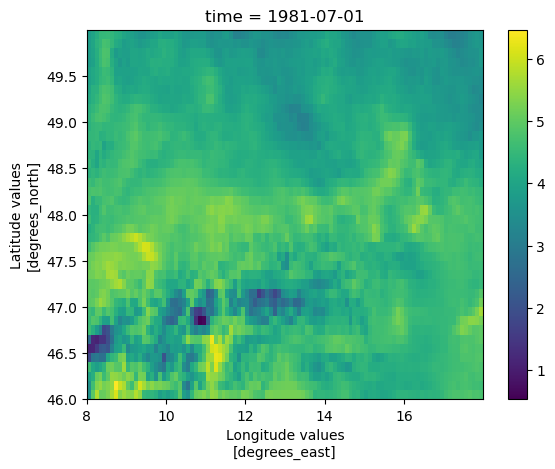

In [116]:
date_test = "1981-07-01"
plot = ET0_fao.sel(time=date_test)
plot.plot()

In [117]:
# Step 5: Save the result to a new netCDF file
ET0_fao.to_netcdf('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/ET0_penman_monteith_fao_itp.nc')

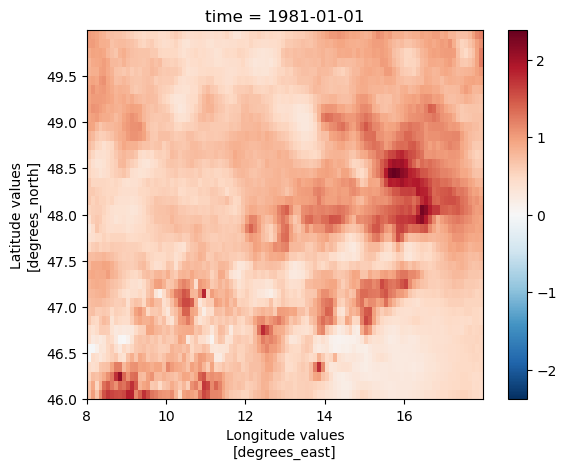

In [118]:
# plot it 
date_test = "1981-01-01"
plot = ET0_fao.sel(time=date_test)
plot.plot()

Final variables: 
- temperature not changed [°C]
- wind: FG:cl_xr_2m [m/s]
- slope of saturation vapour pressure curve: delta_svp [kPa / °C]
- Atmospheric pressure: p_atmos[kPa] - not a time series
- psychrometric constant: psych_const [kPa / °C] - not a time series
- mean saturation vapour pressure: svp_mean [kPa]
- inverse relative disctance: inverse_rel_dist [m ??]
- solar declination: solar_declination
- sunset_angle
- extraterrestrial_radiation [MJ / m2 / d]
- clear_sky_radiation
- net_shortwave_radiation
- net_out_longwave
- net_radiation

# 5. Zonal Stats with Area Weightings (uxing Xagg)
https://climateestimate.net/content/example-step3.html

In [ ]:
# create weightmap, can be any variable I think
weightmap = xa.pixel_overlaps(RR_cl_xr, shape_C_4326,subset_bbox=False)


In [ ]:
# weightmap PET last (it's the same just repeating) 
weightmap = xa.pixel_overlaps(PET_last_mm_cl_xr, shape_C_4326,subset_bbox=False)

In [121]:
# weightmap PET last (it's the same just repeating) 
weightmap = xa.pixel_overlaps(ET0_fao, shape_C_4326,subset_bbox=False)

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!


## 5.1 Aggregate EOBS vars, Albedo and PET to catchments

In [ ]:
# minimum temperature
TN_aggregated_xagg = xa.aggregate(TN_cl_xr, weightmap)

In [ ]:
# save to csv 
TN_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/TN_aggregated_xagg_xr.csv')

In [ ]:
# mean temperature
TG_aggregated_xagg = xa.aggregate(TG_cl_xr, weightmap)

In [ ]:
# save to csv
TG_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/TG_aggregated_xagg_xr.csv')

In [ ]:
# maximum temperature
TX_aggregated_xagg = xa.aggregate(TX_cl_xr, weightmap)

In [ ]:
# save to csv
TX_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/TX_aggregated_xagg_xr.csv')

In [ ]:
# precipitation 
RR_aggregated_xagg = xa.aggregate(RR_cl_xr, weightmap)

In [ ]:
# save to csv 
RR_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/RR_aggregated_xagg_xr.csv')


In [ ]:
# sea level pressure
PP_aggregated_xagg = xa.aggregate(PP_cl_xr, weightmap)

In [ ]:
# save to csv 
PP_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/PP_aggregated_xagg_xr.csv')


In [ ]:
# relative humidity 
HU_aggregated_xagg = xa.aggregate(HU_cl_xr, weightmap)

In [ ]:
# save to csv 
HU_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/HU_aggregated_xagg_xr.csv')


In [ ]:
# wind speed # make sure to take the right one! 
# we are now taking the original at 10 m, not the one we used in the Penman equation
FG_aggregated_xagg = xa.aggregate(FG_cl_xr_shifted, weightmap)

In [ ]:
# save to csv 
FG_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/FG_aggregated_xagg_xr.csv')


In [ ]:
# shortwave radiation 
QQ_aggregated_xagg = xa.aggregate(QQ_cl_xr, weightmap)

In [ ]:
# save to csv 
QQ_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/QQ_aggregated_xagg_xr.csv')


In [ ]:
# albedo 
ALB_aggregated_xagg = xa.aggregate(ALB_cl_xr, weightmap)

In [ ]:
# save to csv 
ALB_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/ALB_aggregated_xagg_xr.csv')

In [122]:
# calculated PET fao 
# albedo 
ET0_fao_aggregated_xagg = xa.aggregate(ET0_fao, weightmap)

/Users/jonathanschieren/opt/anaconda3/envs/hydromt/lib/python3.10/site-packages/xagg/core.py:521: UserWarning: An unnamed xr.DataArray was inputted instead of a xr.Dataset; the output variable will be "var"
  warnings.warn('An unnamed xr.DataArray was inputted instead of a xr.Dataset; the output variable will be "var"')


aggregating var...
all variables aggregated to polygons!


In [123]:
# save to csv 
ET0_fao_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/ET0_fao_aggregated_xagg_xr.csv')


/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/ET0_fao_aggregated_xagg_xr.csv saved!


In [ ]:
# PET from ERA5Land last
PET_last_aggregated_xagg = xa.aggregate(PET_last_mm_cl_xr, weightmap)

In [ ]:
# save to CSV
PET_last_aggregated_xagg.to_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/PET_last_era5land_aggregated_xagg_xr.csv')


## 5.2 Save as individual catchments

In [ ]:
# load minimum temp
TN_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/TN_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'tn'])

In [ ]:
# load mean temp
TG_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/TG_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'tg'])

In [ ]:
# maximum temp
TX_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/TX_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'tx'])

In [ ]:
# load precipitation
RR_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/RR_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'rr'])

In [ ]:
# load sea level pressure
PP_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/PP_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'pp'])

In [ ]:
# load relative humidity
HU_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/HU_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'hu'])

In [ ]:
# wind speed 
FG_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/FG_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'fg'])

In [127]:
# shortwave radiation 
QQ_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/QQ_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'qq'])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/QQ_aggregated_xagg_xr.csv'

In [ ]:
# open albedo 
ALB_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/ALB_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'fal'])

In [124]:
# open ET0 Penman 
ET0_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/ET0_fao_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'var'])


In [125]:
# rename column in ET0 Penman 
ET0_xagg.rename(columns={'var': 'ET0'}, inplace=True)

In [126]:
ET0_xagg # pet_2.set_index('time', inplace=True)

,time,ID,ET0
0,1981-01-01,196,0.852671
1,1981-01-02,196,0.426396
2,1981-01-03,196,0.511462
3,1981-01-04,196,0.581232
4,1981-01-05,196,0.471779
...,...,...,...
6798645,2021-12-27,197,0.196464
6798646,2021-12-28,197,0.213820
6798647,2021-12-29,197,0.388367
6798648,2021-12-30,197,0.422486


In [ ]:
# open PET last 
PET_last_xagg = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_new/PET_last_era5land_aggregated_xagg_xr.csv', usecols=['ID', 'time', 'pev'])


In [ ]:
PET_last_xagg

In [130]:
# save all catchments as individual csv files 
path = '/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_individual_et0/'
for IDs in shape_C_4326.ID:
    
    print(IDs)
    et0 = ET0_xagg[ET0_xagg['ID']==IDs]

    
    # drop the ID columns drop time columns for all vars except precipitation
    et0 = et0.drop(['ID'], axis = 1)

    et0.to_csv(path + "ID_" + str(IDs) + ".csv")


196
595
377
113
441
383
366
200
388
378
202
583
98
395
169
95
584
391
590
176
102
177
189
432
174
578
144
593
439
264
437
143
588
265
148
266
586
269
268
151
134
575
236
430
230
132
139
594
577
241
238
138
630
142
479
242
140
587
295
416
412
119
581
220
585
214
429
116
131
622
222
626
219
469
130
286
624
162
465
297
167
294
629
627
605
296
298
608
171
319
618
611
185
464
318
190
623
283
195
683
518
607
284
604
285
606
603
456
498
509
40
662
508
512
42
41
631
480
635
488
485
634
492
491
661
506
703
695
534
539
704
536
551
483
545
632
694
533
693
692
535
725
43
523
520
682
525
688
687
524
106
103
726
572
571
110
564
723
104
105
556
559
109
107
563
108
758
743
312
762
179
183
316
181
756
748
753
401
750
390
172
757
299
777
309
784
308
741
315
574
337
210
205
740
742
335
344
774
340
600
213
217
773
776
359
356
215
325
779
327
778
326
770
769
334
204
330
599
772
243
598
245
446
247
771
601
198
246
823
766
329
641
331
328
764
199
768
408
233
746
410
795
428
411
235
239
754
436
431
270
272
82

In [139]:
def invert_pet(input_folder1, input_folder2, output_folder, id_list):
    for id_num in id_list:
        input_file1 = os.path.join(input_folder1, f"ID_{id_num}.csv")
        input_file2 = os.path.join(input_folder2, f"ID_{id_num}.csv")
        output_file = os.path.join(output_folder, f"ID_{id_num}.csv")
        
        # read
        data1 = pd.read_csv(input_file1)
        data2 = pd.read_csv(input_file2)
        
        selected_columns = ['time', 'rr', 'tg', 'tn', 'tx', 'pp', 'hu', 'fg', 'qq', 'fal', 'DOY', 'daylength', 'pev']
        combined_data = pd.concat([data1[selected_columns], data2[['ET0']]], axis=1)
        combined_data.set_index('time', inplace=True)
        
        # Save the updated data to a new CSV file
        combined_data.to_csv(output_file, index=True)
        
        print(f"ID: {id_num}")

In [144]:
IDs = IDs.astype(int)

In [145]:
IDs

array([196, 595, 377, 113, 441, 383, 366, 200, 388, 378, 202, 583,  98,
       395, 169,  95, 584, 391, 590, 176, 102, 177, 189, 432, 174, 578,
       144, 593, 439, 264, 437, 143, 588, 265, 148, 266, 586, 269, 268,
       151, 134, 575, 236, 430, 230, 132, 139, 594, 577, 241, 238, 138,
       630, 142, 479, 242, 140, 587, 295, 416, 412, 119, 581, 220, 585,
       214, 429, 116, 131, 622, 222, 626, 219, 469, 130, 286, 624, 162,
       465, 297, 167, 294, 629, 627, 605, 296, 298, 608, 171, 319, 618,
       611, 185, 464, 318, 190, 623, 283, 195, 683, 518, 607, 284, 604,
       285, 606, 603, 456, 498, 509,  40, 662, 508, 512,  42,  41, 631,
       480, 635, 488, 485, 634, 492, 491, 661, 506, 703, 695, 534, 539,
       704, 536, 551, 483, 545, 632, 694, 533, 693, 692, 535, 725,  43,
       523, 520, 682, 525, 688, 687, 524, 106, 103, 726, 572, 571, 110,
       564, 723, 104, 105, 556, 559, 109, 107, 563, 108, 758, 743, 312,
       762, 179, 183, 316, 181, 756, 748, 753, 401, 750, 390, 17

In [146]:
# Specify input and output paths and ID list
input_folder_path1 = "/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_individual_final/timeseries/forcings_c_xagg/"
input_folder_path2 = "/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_individual_et0/"
output_folder_path = "/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_timeseries/"

# Call the function
invert_pet(input_folder_path1, input_folder_path2, output_folder_path, IDs)

ID: 196
ID: 595
ID: 377
ID: 113
ID: 441
ID: 383
ID: 366
ID: 200
ID: 388
ID: 378
ID: 202
ID: 583
ID: 98
ID: 395
ID: 169
ID: 95
ID: 584
ID: 391
ID: 590
ID: 176
ID: 102
ID: 177
ID: 189
ID: 432
ID: 174
ID: 578
ID: 144
ID: 593
ID: 439
ID: 264
ID: 437
ID: 143
ID: 588
ID: 265
ID: 148
ID: 266
ID: 586
ID: 269
ID: 268
ID: 151
ID: 134
ID: 575
ID: 236
ID: 430
ID: 230
ID: 132
ID: 139
ID: 594
ID: 577
ID: 241
ID: 238
ID: 138
ID: 630
ID: 142
ID: 479
ID: 242
ID: 140
ID: 587
ID: 295
ID: 416
ID: 412
ID: 119
ID: 581
ID: 220
ID: 585
ID: 214
ID: 429
ID: 116
ID: 131
ID: 622
ID: 222
ID: 626
ID: 219
ID: 469
ID: 130
ID: 286
ID: 624
ID: 162
ID: 465
ID: 297
ID: 167
ID: 294
ID: 629
ID: 627
ID: 605
ID: 296
ID: 298
ID: 608
ID: 171
ID: 319
ID: 618
ID: 611
ID: 185
ID: 464
ID: 318
ID: 190
ID: 623
ID: 283
ID: 195
ID: 683
ID: 518
ID: 607
ID: 284
ID: 604
ID: 285
ID: 606
ID: 603
ID: 456
ID: 498
ID: 509
ID: 40
ID: 662
ID: 508
ID: 512
ID: 42
ID: 41
ID: 631
ID: 480
ID: 635
ID: 488
ID: 485
ID: 634
ID: 492
ID: 491
ID: 661
ID: 5

In [147]:
# final 
final = pd.read_csv('/Users/jonathanschieren/Desktop/msc_thesis/data/e_obs/xagg_timeseries/ID_196.csv')


In [148]:
final

,time,rr,tg,tn,tx,pp,hu,fg,qq,fal,DOY,daylength,pev,ET0
0,1981-01-01,4.444643,-0.238348,-1.709652,2.477619,1018.456501,78.298095,8.465447,12.354214,0.288486,1,8.164445,2.393820,0.852671
1,1981-01-02,21.059161,-1.336606,-2.197946,-0.612438,1019.419702,89.072637,6.792040,11.564901,0.315364,2,8.179501,1.640947,0.426396
2,1981-01-03,16.189809,1.759364,-0.444176,3.132425,1003.719716,88.273308,8.113271,18.564901,0.343245,3,8.195902,2.109484,0.511462
3,1981-01-04,6.463435,1.386677,0.001495,3.134937,1002.321871,81.828016,4.126285,19.443023,0.338665,4,8.213634,1.201104,0.581232
4,1981-01-05,3.377142,-2.611175,-4.414074,-0.257066,1011.698653,83.871471,5.376712,20.564901,0.340310,5,8.232680,2.001049,0.471779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970,2021-12-27,0.000000,-1.801553,-5.467195,1.574907,934.029984,92.474956,1.280470,27.772092,0.232940,361,8.109763,0.347911,0.179130
14971,2021-12-28,12.914882,-0.196770,-3.670292,2.356230,931.504372,94.446596,1.302073,23.645786,0.226677,362,8.117918,0.250693,0.207249
14972,2021-12-29,4.231551,2.755452,-0.116266,5.467916,934.931869,92.121256,2.596849,12.000000,0.195948,363,8.127473,0.071486,0.380487
14973,2021-12-30,2.547388,7.643052,2.482380,10.867060,948.037064,93.739080,2.290912,13.000000,0.162930,364,8.138419,-0.091218,0.413047


# 6. Runoff Time Series (LamaH-CE)
Runoff time series in LamaH were interpolated when gaps where smaller than 6 h. 

Here we analyze how long the time series are and which ones contain gaps and how large those gaps are. 



## 6.1 Gauge Attributes

In [ ]:
# IDs in catchment delineation C (this is created further up) 
IDs

In [ ]:
# load file with gauge attributes (this is for ALL gauges)
gauge_attrs = pd.read_csv("/Users/jonathanschieren/Desktop/msc_thesis/data/lamah/hourly/D_gauges/1_attributes/Gauge_attributes_MOD.csv", delimiter=",")


In [ ]:
gauge_attrs.head(2)

In [ ]:
# subset of gauge attributes that includes only the gauges used in catchment delineation C
gauge_attrs_C = gauge_attrs[gauge_attrs['ID'].isin(IDs)]
gauge_attrs_C.head()

In [ ]:
gauge_attrs_C.columns

In [ ]:
gap_count = gauge_attrs_C['gaps_post'].value_counts()

In [ ]:
gap_count

In [ ]:
plt.bar(gauge_attrs_C['ID'], gauge_attrs_C['gaps_post'])

In [ ]:
# df that includes only the gauges/IDs that are gap free
gauge_attrs_C_nogap = gauge_attrs_C[gauge_attrs_C['gaps_post'] == 0.0]

# array with gap free IDs
IDs_nogap = gauge_attrs_C[gauge_attrs_C['gaps_post'] == 0.0]['ID'].values

In [ ]:
gauge_attrs_C_nogap.tail()

In [ ]:
gauge_attrs_C_nogap.shape

## 6.2 Inspect start and end time of the gap-free time series

In [ ]:
runoff_path = "/Users/jonathanschieren/Desktop/msc_thesis/data/lamah/hourly/D_gauges/2_timeseries/daily/"


In [ ]:
csv_files = glob.glob(os.path.join(runoff_path, "ID_*.csv"))

for file_path in csv_files:
    file_name = os.path.basename(file_path)
    file_id = int(file_name.split('_')[1][:-4])  # Extract the ID from the file name
    
    if file_id in IDs_nogap:
        df = pd.read_csv(file_path, delimiter=";")

        first_date = df.iloc[0]
        last_date = df.iloc[-1]
        print(f"File: {file_name}")
        first = first_date['YYYY'].astype(int)
        last = last_date['YYYY'].astype(int)
        print(f"First Date: {first_date['YYYY'].astype(int)}-{first_date['MM'].astype(int)}-{first_date['DD'].astype(int)}")
        print(f"Last Date: {last_date['YYYY'].astype(int)}-{last_date['MM'].astype(int)}-{last_date['DD'].astype(int)}")
        print("")


In [ ]:
# Date range boundaries
start_date = dt(1981, 1, 1)
end_date = dt(2017, 12, 31)

# List to store the filtered IDs
filtered_ids = []

# Loop through the CSV files in the folder
csv_files = glob.glob(os.path.join(runoff_path, "ID_*.csv"))

for file_path in csv_files:
    file_name = os.path.basename(file_path)
    file_id = int(file_name.split('_')[1][:-4])  # Extract the ID from the file name
    
    if file_id in IDs_nogap:
        df = pd.read_csv(file_path, delimiter=";")
        
        # Convert "YYYY", "MM", "DD" columns to a datetime object
        df['Date'] = pd.to_datetime(df[['YYYY', 'MM', 'DD']].astype(str).apply('-'.join, axis=1))
        
        first_date = df.iloc[0]['Date']
        last_date = df.iloc[-1]['Date']
        
        if start_date == first_date and last_date == end_date:
            filtered_ids.append(file_id)
            
            print(f"File: {file_name}")
            print(f"First Date: {first_date}")
            print(f"Last Date: {last_date}")
            print("")

print("Filtered IDs:", filtered_ids)

In [ ]:
# save filtered IDs 
csv_file_path = "/Users/jonathanschieren/Desktop/msc_thesis/data/lamah/hourly/C_basins_intermediate_lowimp/IDs_nogap_fullperiod.csv"
pd.DataFrame({"Filtered IDs": filtered_ids}).to_csv(csv_file_path, index=False)